# Regression Analysis for Sentiment

> Copyright 2019 Dave Fernandes. All Rights Reserved.
> 
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
>
> http://www.apache.org/licenses/LICENSE-2.0
>  
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

## Overview
This notebook performs regression to predict sentiment and helpfulness scores from text reviews.
- Data for this analysis should be prepared using the `Preprocessing.ipynb` notebook from this project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

import tensorflow as tf
tf.enable_eager_execution()

PREDICT_SCORE = True  # Predicts helpfulness if False

MODEL_DIR = './data/Regression' if PREDICT_SCORE else './data/HRegression'
INPUT_DIR = './data/TFRecords'

TRAIN_REVIEW = 'train_text_512'
TRAIN_SUMMARY = 'train_summary'
TRAIN_SCORES = 'train_values'

TEST_REVIEW = 'test_text_512'
TEST_SUMMARY = 'test_summary'
TEST_SCORES = 'test_values'

def rec_path(filename):
    return os.path.join(INPUT_DIR, filename + '.tfrec')

### Mapping function for scores dataset
- Includes normalization

In [2]:
def parse_score_record(example):
    # Features in scores TFRecord file
    F_SCORE = 'score'              # Review score (1-5)
    F_VOTES = 'votes'              # Number of up/down votes
    F_HELPFULNESS  = 'helpfulness' # Fraction of up-votes

    features_desc = {
        F_SCORE: tf.FixedLenFeature([], tf.int64),
        F_VOTES: tf.FixedLenFeature([], tf.int64),
        F_HELPFULNESS: tf.FixedLenFeature([], tf.float32),
        }
    features = tf.parse_single_example(example, features=features_desc)
    
    score = tf.to_float(features[F_SCORE])
    votes = features[F_VOTES]
    helpfulness = features[F_HELPFULNESS]
    
    # Normalize to zero mean and unit range
    normed_score = (score - 3.0) * 0.5
    
    return normed_score, helpfulness, votes

### Mapping function for review text dataset
- BERT feature vectors for each review or summary

In [3]:
FEATURE_VECTOR_LENGTH = 768*4

def parse_review_record(example):
    # Features in reviews TFRecord file
    F_LENGTH = 'vector_length' # Length of each feature vector
    F_COUNT = 'vector_count'   # Count of feature vectors in list
    F_VECTORS  = 'vector_list' # List of feature vectors

    features_desc = {
        F_LENGTH: tf.FixedLenFeature([], tf.int64),
        F_COUNT: tf.FixedLenFeature([], tf.int64),
        F_VECTORS: tf.FixedLenFeature([1, FEATURE_VECTOR_LENGTH], tf.float32),
        }
    features = tf.parse_single_example(example, features=features_desc)
    
    v_length = features[F_LENGTH]
    v_count = features[F_COUNT]
    v_list = features[F_VECTORS]
    
    return v_list

### Input functions for Estimator

In [4]:
FEATURE_VECTOR_COUNT = 2
REGRESSION_LABEL_COUNT = 1

def combine_records(review_vec, summary_vec, score_tuple):
    # Combine feature vectors for review and summary into a matrix
    text_embeddings = tf.concat([review_vec, summary_vec], axis=1)
    
    features = {'text_embeddings': text_embeddings, 'votes': score_tuple[2]}
    labels = score_tuple[0] if PREDICT_SCORE else score_tuple[1]
    return features, labels

def filter_votes(features, labels):
    return features['votes'] > 1

def combined_dataset(review_file, summary_file, score_file):
    review_set = tf.data.TFRecordDataset([rec_path(review_file)]).map(parse_review_record)
    summary_set = tf.data.TFRecordDataset([rec_path(summary_file)]).map(parse_review_record)
    score_set = tf.data.TFRecordDataset([rec_path(score_file)]).map(parse_score_record)
    combined_set = tf.data.Dataset.zip((review_set, summary_set, score_set)).map(combine_records)
    
    if PREDICT_SCORE:
        combined_set = combined_set.filter(filter_votes)
    return combined_set

def train_input_fn():
    dataset = combined_dataset(TRAIN_REVIEW, TRAIN_SUMMARY, TRAIN_SCORES)
    return dataset.repeat().shuffle(20000).batch(200).prefetch(1)

def eval_input_fn():
    dataset = combined_dataset(TEST_REVIEW, TEST_SUMMARY, TEST_SCORES)
    return dataset.batch(1000).prefetch(1)

PLOT_BATCH_SIZE = 1000
PLOT_BATCH_COUNT = 5
PLOT_POINT_COUNT = PLOT_BATCH_SIZE * PLOT_BATCH_COUNT

def plot_train_input_fn():
    dataset = combined_dataset(TRAIN_REVIEW, TRAIN_SUMMARY, TRAIN_SCORES)
    return dataset.batch(PLOT_BATCH_SIZE).take(PLOT_BATCH_COUNT)

def plot_test_input_fn():
    dataset = combined_dataset(TEST_REVIEW, TEST_SUMMARY, TEST_SCORES)
    return dataset.batch(PLOT_BATCH_SIZE).take(PLOT_BATCH_COUNT)

### Define model
A set of 1D convolutional layers apply the same filters independently to the feature vectors for the review text and the summary text. The output of the convolutional layers is then optionally max-pooled and feeds into a fully connected network.

In [5]:
# Initial learning rate
INITIAL_LEARNING_RATE = 0.0001

# Learning rate decay per thousand steps (1.0 = no decay)
LR_DECAY_PER_THOUSAND = 1.0

def news_model_fn(features, labels, mode, params):
    is_training = mode == tf.estimator.ModeKeys.TRAIN
    conv_batch_normalize = params['conv_batch_normalize']
    fc_batch_normalize = params['fc_batch_normalize']
    l2_conv = 0.002 if conv_batch_normalize else 0.01
    l2_fc = 0.002 if fc_batch_normalize else 0.01
    use_conv_tanh = params['use_conv_tanh']
    use_fc_tanh = params['use_fc_tanh']
    
    current_layer = tf.feature_column.input_layer(features, params['feature_columns'])
    current_layer = tf.expand_dims(tf.layers.flatten(current_layer, name='flatten_input'), -1)
    
    for i, units in enumerate(params['conv_filters']):
        if i == 0:
            kernel_size = FEATURE_VECTOR_LENGTH,
            strides = FEATURE_VECTOR_LENGTH,
        else:
            kernel_size = 1,
            strides = 1,
            
        current_layer = tf.layers.conv1d(current_layer,
            name='conv1d_' + str(i+1),
            filters=units,
            data_format='channels_last',
            kernel_size=kernel_size,
            strides=strides,
            padding='valid',
            kernel_initializer=tf.glorot_normal_initializer(),
            kernel_regularizer=tf.keras.regularizers.l2(l=l2_conv),
            bias_regularizer=tf.keras.regularizers.l2(l=l2_conv),
            activation=None)
        
        if conv_batch_normalize:
            current_layer = tf.keras.layers.BatchNormalization(axis=2, scale=use_conv_tanh, renorm=True)(current_layer, training=is_training)
        current_layer = tf.keras.activations.tanh(current_layer) if use_conv_tanh else tf.keras.activations.relu(current_layer)

    current_layer = tf.layers.flatten(current_layer)
    
    for i, units in enumerate(params['hidden_units']):
        current_layer = tf.layers.dense(current_layer,
            name='dense_' + str(i+1),
            units=units,
            kernel_initializer=tf.glorot_normal_initializer(),
            kernel_regularizer=tf.keras.regularizers.l2(l=l2_fc),
            bias_regularizer=tf.keras.regularizers.l2(l=l2_fc),
            activation=None)

        if fc_batch_normalize:
            current_layer = tf.keras.layers.BatchNormalization(axis=1, scale=use_fc_tanh, renorm=True)(current_layer, training=is_training)
        current_layer = tf.keras.activations.tanh(current_layer) if use_fc_tanh else tf.keras.activations.relu(current_layer)

    regression_layer = tf.layers.dense(current_layer,
        name='linear_output',
        units=REGRESSION_LABEL_COUNT,
        kernel_initializer=tf.glorot_normal_initializer(),
        kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
        bias_regularizer=tf.keras.regularizers.l2(l=0.01),
        activation=None)

    # For prediction, exit here
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'predictions': regression_layer,
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # For training and evaluation, compute the loss (MSE)
    labels = tf.reshape(labels, tf.shape(regression_layer))
    loss = tf.losses.mean_squared_error(labels, regression_layer)

    abs_error = tf.metrics.mean_tensor(tf.reduce_mean(tf.abs(labels - regression_layer), axis=0))
    metrics = {'abs_error': abs_error}
    tf.summary.tensor_summary('abs_error', abs_error)

    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=metrics)

    # For training...
    global_step = tf.train.get_global_step()
    learning_rate = tf.train.exponential_decay(INITIAL_LEARNING_RATE, global_step, 1000, LR_DECAY_PER_THOUSAND)

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

### Train model

In [6]:
feature_columns = [tf.feature_column.numeric_column('text_embeddings', [FEATURE_VECTOR_COUNT, FEATURE_VECTOR_LENGTH])]

regressor = tf.estimator.Estimator(
    model_fn=news_model_fn,
    model_dir=MODEL_DIR,
    params={
        'feature_columns': feature_columns,
        'conv_filters': [300, 30, 15],
        'hidden_units': [30, 8],
        'conv_batch_normalize': False,
        'fc_batch_normalize': False,
        'use_conv_tanh': True,
        'use_fc_tanh': True,
    })

#regressor.train(train_input_fn, steps=2000)

#info = regressor.evaluate(input_fn=eval_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './data/Regression', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0xb3e3b8ba8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Plot the predictions

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./data/Regression/model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


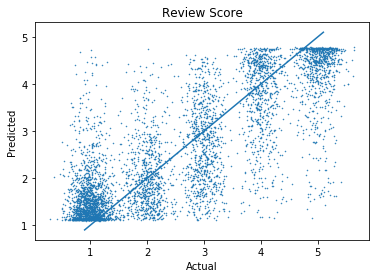

In [7]:
dataset_fn = eval_input_fn
REGRESSION_LABEL_COUNT = 1

predictions = regressor.predict(input_fn=dataset_fn)
dataset = dataset_fn()
actual = None
predicted = []

for i, value in enumerate(predictions):
    predicted.append(value['predictions'])

j = 0
for x, y in dataset:
    batch = y.numpy()
    sd = 0.1 if PREDICT_SCORE else 0.03
    noise = np.random.normal(0.0, sd, np.size(batch))
    #noise = np.random.random(np.size(batch)) - 0.5
    noisy_actual = batch + np.reshape(noise, np.shape(batch))
    
    if j == 0:
        actual = batch
        abscissa = noisy_actual
    else:
        actual = np.concatenate((actual, batch), axis=0)
        abscissa = np.concatenate((abscissa, noisy_actual), axis=0)
        
    j += np.shape(batch)[0]

actual = np.reshape(actual, (len(actual), REGRESSION_LABEL_COUNT))
abscissa = np.reshape(abscissa, (len(abscissa), REGRESSION_LABEL_COUNT))
predicted = np.reshape(predicted, (len(predicted), REGRESSION_LABEL_COUNT))
if PREDICT_SCORE:
    actual = actual * 2 + 3
    abscissa = abscissa * 2 + 3
    predicted = predicted * 2 + 3
title = 'Review Score' if PREDICT_SCORE else 'Helpfulness'

if PREDICT_SCORE:
    plt.plot([0.9, 5.1], [0.9, 5.1])
else:
    plt.plot([-0.1, 1.1], [-0.1, 1.1])
    
plt.scatter(abscissa[:PLOT_POINT_COUNT], predicted[:PLOT_POINT_COUNT], marker='.', s=1)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title(title)
plt.show()

del abscissa
del dataset

### Examine data that are not fit well by model

In [14]:
import csv
import linecache

REVIEW_FILEPATH = './data/test_text.txt'
SUMMARY_FILEPATH = './data/test_summary.txt'
OUT_FILE_PREFIX = './data/test'

output_list = []
for index in range(len(predicted)):
    review = linecache.getline(REVIEW_FILEPATH, index + 1)
    summary = linecache.getline(SUMMARY_FILEPATH, index + 1)
    output_list.append((np.reshape(actual[index], ()), np.reshape(predicted[index], ()), summary, review))

with open(OUT_FILE_PREFIX + '.csv','w') as out_file:
    csv_file = csv.writer(out_file)
    csv_file.writerow(['Actual', 'Predicted', 'Summary','Review'])

    for row in output_list:
        csv_file.writerow(row)

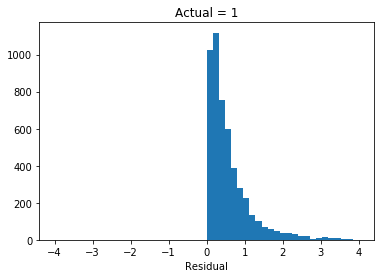

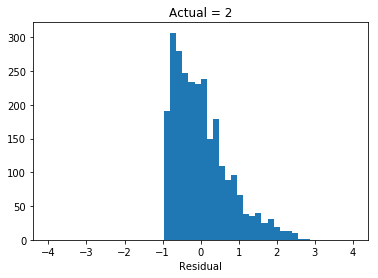

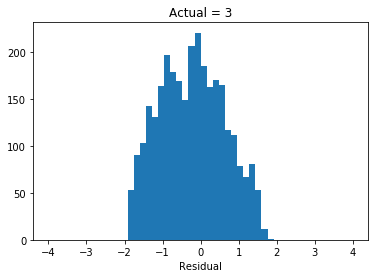

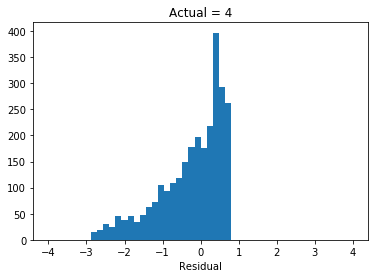

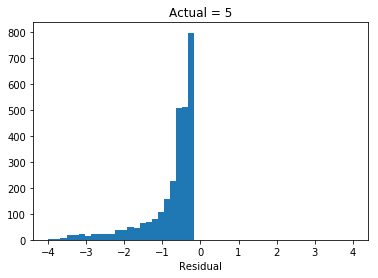

In [15]:
import csv
import linecache

REVIEW_FILEPATH = './data/test_text.txt'
SUMMARY_FILEPATH = './data/test_summary.txt'
OUT_FILE_PREFIX = './data/residuals_'

if PREDICT_SCORE:
    residuals = predicted - actual
    
    for i in range(1, 6):
        original_index = np.where(actual == i)[0]
        res = residuals[original_index]
        n, bins, patches = plt.hist(res[:PLOT_POINT_COUNT], 50, (-4, 4))
        plt.xlabel('Residual')
        plt.title('Actual = ' + str(i))
        plt.show()
        
        output_list = []
        for index in original_index:
            review = linecache.getline(REVIEW_FILEPATH, index + 1)
            summary = linecache.getline(SUMMARY_FILEPATH, index + 1)
            output_list.append((predicted[index], summary, review))
        
        output_list.sort(key=lambda tuple: tuple[0])
        
        with open(OUT_FILE_PREFIX + str(i) + '.csv','w') as out_file:
            csv_file = csv.writer(out_file)
            csv_file.writerow(['Predicted', 'Summary','Review'])
            
            for row in output_list:
                csv_file.writerow(row)